# Baseline xG (Goal vs Non-Goal) — Skeleton

We'll load ../data/xgoal-db.sqlite if present, build simple geometry/context features, train a calibrated Logistic Regression, and produce basic metrics + explanations. Non-penalty, non-own-goal only. Everything is guarded so the notebook runs even when the DB is missing.


In [1]:
# Core
import os, sqlite3, math, json
from pathlib import Path

# Data
import numpy as np
import pandas as pd

# Modeling
from sklearn.model_selection import GroupKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, log_loss, brier_score_loss
from sklearn.impute import SimpleImputer

# Plots
import matplotlib.pyplot as plt

# Repro
SEED = 42
np.random.seed(SEED)

# ---- Config ----
DB_PATH = Path("../data/xgoal-db.sqlite")   # <— YOUR DB path
USE_MATERIALIZED_WIDE = True                # if table shots_wide exists, use it
PRINT_ROWS = 5


In [2]:
WIDE_CTE_SQL = """
WITH ff AS (
    SELECT
        shot_id,
        COUNT(*)                                                AS ff_count,
        SUM(CASE WHEN teammate = 1 THEN 1 ELSE 0 END)          AS ff_teammates,
        SUM(CASE WHEN teammate = 0 THEN 1 ELSE 0 END)          AS ff_opponents,
        SUM(CASE WHEN keeper   = 1 THEN 1 ELSE 0 END)          AS ff_keeper_count,
        AVG(CASE WHEN keeper   = 1 THEN x END)                 AS ff_keeper_x,
        AVG(CASE WHEN keeper   = 1 THEN y END)                 AS ff_keeper_y
    FROM freeze_frames
    GROUP BY shot_id
)
SELECT
    s.*,
    e.under_pressure       AS event_under_pressure,
    e.counterpress         AS event_counterpress,
    e.duration             AS event_duration,
    ff.ff_count,
    ff.ff_teammates,
    ff.ff_opponents,
    ff.ff_keeper_count,
    ff.ff_keeper_x,
    ff.ff_keeper_y
FROM shots s
LEFT JOIN events e ON e.event_id = s.shot_id
LEFT JOIN ff     ON ff.shot_id   = s.shot_id;
"""

def load_wide_df(db_path: Path, use_materialized: bool = True) -> pd.DataFrame | None:
    if not db_path.exists():
        print(f"[info] DB not found at {db_path.resolve()}. Proceeding with skeleton only.")
        return None
    with sqlite3.connect(db_path) as conn:
        tables = set(pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)["name"])
        if "shots_wide" in tables and use_materialized:
            df = pd.read_sql("SELECT * FROM shots_wide;", conn)
        else:
            df = pd.read_sql(WIDE_CTE_SQL, conn)
    if not df.empty and not df["shot_id"].is_unique:
        raise ValueError("shot_id must be unique (one row per shot)")
    return df

df = load_wide_df(DB_PATH, USE_MATERIALIZED_WIDE)
print("[info] df is", None if df is None else df.shape)
if df is not None:
    display(df.head(PRINT_ROWS))


[info] df is (88023, 50)


,shot_id,match_id,team_id,opponent_team_id,player_id,possession,possession_team_id,period,minute,second,...,freeze_frame_count,event_under_pressure,event_counterpress,event_duration,ff_count,ff_teammates,ff_opponents,ff_keeper_count,ff_keeper_x,ff_keeper_y
0,6a0741a9-8324-48ad-9647-04a342bd9e39,0,241,239,7149,2,241,1,0,15.0,...,10,NaN,None,0.112927,10.0,2.0,8.0,1.0,118.9,41.8
1,ccb673c1-37ca-48c0-9249-927469dccf9b,0,220,217,3496,3,220,1,0,20.0,...,11,NaN,None,0.403501,11.0,4.0,7.0,1.0,118.8,39.7
2,44befb97-6618-48a9-8607-8da6c605f339,0,220,217,19677,3,220,1,0,22.0,...,8,NaN,None,0.684151,8.0,2.0,6.0,1.0,119.2,41.3
3,5f0f0db7-2548-4ca9-9eb6-71b7b96448f1,0,178,872,20359,3,178,1,0,44.0,...,17,1.0,None,0.854850,17.0,7.0,10.0,1.0,118.5,36.0
4,f6cb589b-95a2-49bb-9c95-2982e02ff65b,0,160,146,10616,3,160,1,0,46.0,...,13,NaN,None,1.010053,13.0,4.0,9.0,1.0,119.0,39.8


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88023 entries, 0 to 88022
Data columns (total 50 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   shot_id                 88023 non-null  object 
 1   match_id                88023 non-null  int64  
 2   team_id                 88023 non-null  int64  
 3   opponent_team_id        88023 non-null  int64  
 4   player_id               88023 non-null  int64  
 5   possession              88023 non-null  int64  
 6   possession_team_id      88023 non-null  int64  
 7   period                  88023 non-null  int64  
 8   minute                  88023 non-null  int64  
 9   second                  88023 non-null  float64
 10  timestamp               88023 non-null  object 
 11  play_pattern            88023 non-null  object 
 12  start_x                 88023 non-null  float64
 13  start_y                 88023 non-null  float64
 14  end_x                   88023 non-null

In [4]:
df0 = df.copy()
mask_valid = (~df0["is_penalty"].astype(bool)) & (~df0["is_own_goal"].astype(bool))
data = df0.loc[mask_valid].copy()

y = (data["outcome"] == "Goal").astype(int)
LEAKY = [c for c in ["end_x","end_y","end_z"] if c in data.columns]
data = data.drop(columns=LEAKY, errors="ignore")
print("rows:", len(data), "goals:", int(y.sum()), "base rate:", float(y.mean()))


rows: 86662 goals: 8792 base rate: 0.10145161662551061


In [5]:
SB_LEN, SB_WID = 120.0, 80.0
GOAL_YC_SB = 40.0
GOAL_HALF_W_SB = (7.32/2) * (SB_WID / 68.0)  # ~3.66m scaled to SB units

def distance_sb(x, y):
    dx = SB_LEN - x
    dy = GOAL_YC_SB - y
    return np.hypot(dx, dy)

def opening_angle_deg_sb(x, y):
    left  = np.array([SB_LEN, GOAL_YC_SB - GOAL_HALF_W_SB])
    right = np.array([SB_LEN, GOAL_YC_SB + GOAL_HALF_W_SB])
    p = np.column_stack([x, y])
    v1 = left  - p
    v2 = right - p
    dot = (v1 * v2).sum(axis=1)
    n1 = np.linalg.norm(v1, axis=1)
    n2 = np.linalg.norm(v2, axis=1)
    cosang = np.clip(dot/(n1*n2), -1, 1)
    return np.degrees(np.arccos(cosang))


In [6]:
X = pd.DataFrame(index=data.index)
X["dist_sb"] = distance_sb(data["start_x"].to_numpy(), data["start_y"].to_numpy())
X["angle_deg_sb"] = opening_angle_deg_sb(data["start_x"].to_numpy(), data["start_y"].to_numpy())

def to_num(s):
    if pd.api.types.is_bool_dtype(s):
        return s.fillna(False).astype(int)
    return pd.to_numeric(s, errors="coerce")

for col in ["is_set_piece","is_corner","is_free_kick","first_time","under_pressure"]:
    if col in data.columns:
        X[col] = to_num(data[col].astype("boolean"))
    else:
        X[col] = 0

X["is_header"] = (data.get("body_part", "") == "Head").astype(int) if "body_part" in data.columns else 0

if {"ff_keeper_x","ff_keeper_y"}.issubset(data.columns):
    X["gk_depth_sb"] = np.maximum(0.0, SB_LEN - data["ff_keeper_x"])
    X["gk_offset_sb"] = data["ff_keeper_y"] - GOAL_YC_SB
else:
    X["gk_depth_sb"] = 0.0
    X["gk_offset_sb"] = 0.0

if "ff_opponents" in data.columns:
    X["ff_opponents"] = pd.to_numeric(data["ff_opponents"], errors="coerce")
else:
    X["ff_opponents"] = 0.0


has_gk = (data["freeze_frame_available"]==1) & (data["ff_keeper_count"].fillna(0)>0)
X.loc[has_gk, "gk_depth_sb"]  = np.maximum(0.0, SB_LEN - data.loc[has_gk, "ff_keeper_x"])
X.loc[has_gk, "gk_offset_sb"] = data.loc[has_gk, "ff_keeper_y"] - GOAL_YC_SB
X.loc[~has_gk, ["gk_depth_sb","gk_offset_sb"]] = 0.0

for col in ["first_time","one_on_one","open_goal","follows_dribble","deflected","aerial_won","under_pressure"]:
    X[f"{col}_miss"] = data[col].isna().astype(int)


X = X.apply(pd.to_numeric, errors="coerce")
display(X.describe().T.head(10))


,count,mean,std,min,25%,50%,75%,max
dist_sb,86662.0,19.294575,8.768259,0.4,12.229881,18.638938,25.603515,92.800862
angle_deg_sb,86662.0,27.113283,16.822261,0.0,16.128874,21.084074,33.008305,180.000000
is_set_piece,86662.0,0.049156,0.216196,0.0,0.000000,0.000000,0.000000,1.000000
is_corner,86662.0,0.000323,0.017972,0.0,0.000000,0.000000,0.000000,1.000000
is_free_kick,86662.0,0.048822,0.215497,0.0,0.000000,0.000000,0.000000,1.000000
first_time,86662.0,0.307517,0.461468,0.0,0.000000,0.000000,1.000000,1.000000
under_pressure,86662.0,0.241063,0.427731,0.0,0.000000,0.000000,0.000000,1.000000
is_header,86662.0,0.161132,0.367655,0.0,0.000000,0.000000,0.000000,1.000000
gk_depth_sb,86662.0,2.473439,2.290630,0.0,1.200000,1.900000,3.000000,118.000000
gk_offset_sb,86662.0,0.052172,2.604920,-25.9,-1.500000,0.000000,1.500000,35.100000


In [7]:
def grouped_split(X, y, groups):
    idx = np.arange(len(X))
    if len(idx) == 0:
        return idx, idx

    if groups is None:
        rng = np.random.default_rng(SEED)
        rng.shuffle(idx)
        cut = int(0.8 * len(idx))
        return idx[:cut], idx[cut:]

    groups = pd.Series(groups).reset_index(drop=True)
    unknown_mask = groups.isna() | (groups == 0)
    known_idx = idx[~unknown_mask.to_numpy()]
    unknown_idx = idx[unknown_mask.to_numpy()]

    if len(known_idx) == 0:
        print("[warn] All match_ids are missing/zero; reserving them for test only.")
        return np.array([], dtype=int), unknown_idx

    known_groups = groups.loc[~unknown_mask]
    if known_groups.nunique() < 2 or len(known_idx) < 5:
        rng = np.random.default_rng(SEED)
        rng.shuffle(known_idx)
        cut = int(0.8 * len(known_idx))
        tr_known = known_idx[:cut]
        te_known = known_idx[cut:]
    else:
        n_splits = min(5, int(known_groups.nunique()))
        gkf = GroupKFold(n_splits=n_splits)
        group_values = known_groups.to_numpy()
        tr_loc, te_loc = next(gkf.split(X.iloc[known_idx], y.iloc[known_idx], group_values))
        tr_known = known_idx[tr_loc]
        te_known = known_idx[te_loc]

    test_idx = np.sort(np.concatenate([te_known, unknown_idx]))
    train_mask = np.ones(len(idx), dtype=bool)
    train_mask[test_idx] = False
    train_idx = idx[train_mask]
    return train_idx.astype(int), test_idx.astype(int)

groups = data["match_id"] if "match_id" in data.columns else None
train_idx, test_idx = grouped_split(X, y, groups)

X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

if groups is not None and len(train_idx) > 0 and (pd.Series(groups).iloc[train_idx] == 0).any():
    raise ValueError("match_id=0 should not appear in the training split")

print(X_tr.shape, X_te.shape, float(y_tr.mean()), float(y_te.mean()))


(67443, 18) (19219, 18) 0.10315377429829634 0.09547843280087413


In [8]:
X_tr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67443 entries, 2386 to 88022
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   dist_sb               67443 non-null  float64
 1   angle_deg_sb          67443 non-null  float64
 2   is_set_piece          67443 non-null  int64  
 3   is_corner             67443 non-null  int64  
 4   is_free_kick          67443 non-null  int64  
 5   first_time            67443 non-null  int64  
 6   under_pressure        67443 non-null  int64  
 7   is_header             67443 non-null  int64  
 8   gk_depth_sb           67443 non-null  float64
 9   gk_offset_sb          67443 non-null  float64
 10  ff_opponents          67443 non-null  float64
 11  first_time_miss       67443 non-null  int64  
 12  one_on_one_miss       67443 non-null  int64  
 13  open_goal_miss        67443 non-null  int64  
 14  follows_dribble_miss  67443 non-null  int64  
 15  deflected_miss       

In [9]:
def safe_metrics(y_true, p):
    if len(np.unique(y_true)) < 2:
        return {"auc": np.nan, "logloss": np.nan, "brier": np.nan}
    return {
        "auc": float(roc_auc_score(y_true, p)),
        "logloss": float(log_loss(y_true, p)),
        "brier": float(brier_score_loss(y_true, p))
    }

cal = None
p_raw = None
p_cal = None

if len(X_tr) == 0 or len(np.unique(y_tr)) < 2:
    print("[warn] Not enough training data to fit the model.")
else:
    base = make_pipeline(
        SimpleImputer(strategy="median"),
        StandardScaler(with_mean=True, with_std=True),
        LogisticRegression(max_iter=1000, solver="lbfgs", C=1.0)
    )
    base.fit(X_tr, y_tr)
    p_raw = base.predict_proba(X_te)[:, 1] if len(X_te) else np.array([])
    print("Uncalibrated:", safe_metrics(y_te, p_raw) if len(p_raw) else {"auc": np.nan, "logloss": np.nan, "brier": np.nan})

    cal = CalibratedClassifierCV(base, method="sigmoid", cv="prefit")
    cal.fit(X_tr, y_tr)
    p_cal = cal.predict_proba(X_te)[:, 1] if len(X_te) else np.array([])
    print("Calibrated:", safe_metrics(y_te, p_cal) if len(p_cal) else {"auc": np.nan, "logloss": np.nan, "brier": np.nan})


Uncalibrated: {'auc': 0.8173722963644732, 'logloss': 0.24835381294292713, 'brier': 0.07034081605239793}


/Users/denniskoehn/Library/Caches/pypoetry/virtualenvs/xgoal-tutor-gTwRsLp9-py3.11/lib/python3.11/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Calibrated: {'auc': 0.8173722963644732, 'logloss': 0.24835215704097657, 'brier': 0.07034082754169659}


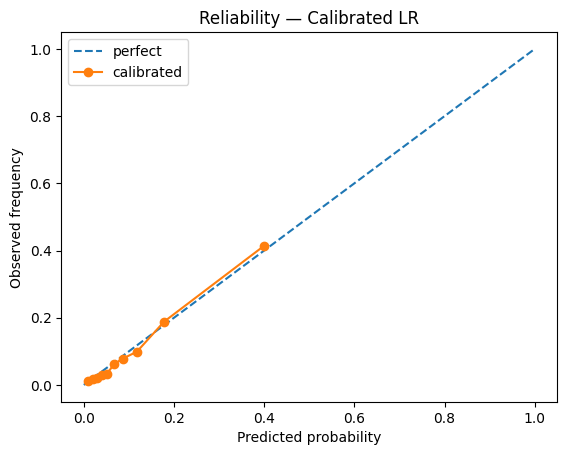

In [10]:
from sklearn.calibration import calibration_curve

if cal is not None and len(X_te) > 50 and len(np.unique(y_te)) == 2:
    prob_true, prob_pred = calibration_curve(y_te, p_cal, n_bins=10, strategy="quantile")
    plt.figure()
    plt.plot([0,1],[0,1], "--", label="perfect")
    plt.plot(prob_pred, prob_true, marker="o", label="calibrated")
    plt.xlabel("Predicted probability")
    plt.ylabel("Observed frequency")
    plt.title("Reliability — Calibrated LR")
    plt.legend(); plt.show()
else:
    print("[info] Skipping reliability plot (not enough test data or model not fit).")


In [16]:
from typing import List, Dict, Any, Tuple
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline

# --- Phrase helpers (same spirit as your Codex snippet, tweak as you like) ---
def distance_phrase(d: float) -> str:
    return "close range" if d < 12 else "medium range" if d < 18 else "long range"

def angle_phrase(a: float) -> str:
    return "wide angle" if a > 25 else "moderate angle" if a > 10 else "tight angle"

def defenders_phrase(n: float) -> str | None:
    if pd.isna(n): return None
    n = int(n)
    if n >= 3: return "crowded sightline"
    if n == 0: return "clear sight"
    return None

def gk_phrase(depth: float, offset: float) -> List[str]:
    parts = []
    if not pd.isna(depth) and depth >= 6: parts.append("keeper high off his line")
    if not pd.isna(offset) and abs(offset) >= 2.5: parts.append("keeper off-center")
    return parts

# --- Strength bucketing for contribution magnitudes (log-odds space) ---
def strength_bucket(v: float) -> str:
    a = abs(v)
    if a >= 0.75: return "strong"
    if a >= 0.35: return "medium"
    if a >= 0.15: return "small"
    return "tiny"

# --- Extract per-row contributions from fitted pipeline ---
def row_contributions(base: Pipeline, row: pd.Series, feature_names: List[str]) -> Tuple[float, pd.Series, float]:
    """
    Returns (logit, contrib_series indexed by feature, intercept)
    """
    imp = base.named_steps["simpleimputer"]
    scl = base.named_steps["standardscaler"]
    lr  = base.named_steps["logisticregression"]

    Xr = row[feature_names].to_frame().T
    X_imp = pd.DataFrame(imp.transform(Xr), columns=feature_names)
    z = pd.Series(scl.transform(X_imp)[0], index=feature_names)
    coef = pd.Series(lr.coef_[0], index=feature_names)
    contrib = coef * z
    intercept = float(lr.intercept_[0])
    logit = float(contrib.sum() + intercept)
    return logit, contrib, intercept

# --- Turn features into human factors (phrase + effect + strength) ---
def factors_from_row_and_contribs(
    row: pd.Series,
    contrib: pd.Series,
    feature_names: List[str],
    topk: int = 6
) -> List[Dict[str, Any]]:
    """
    Builds a de-duplicated list of factors with human phrases and contribution signs.
    Only surfaces meaningful, interpretable features and hides *_miss auxiliaries.
    """
    candidates: List[Tuple[str, str]] = []

    # Geometry
    if "dist_sb" in feature_names:
        candidates.append(("dist_sb", distance_phrase(row.get("dist_sb", np.nan))))
    if "angle_deg_sb" in feature_names:
        candidates.append(("angle_deg_sb", angle_phrase(row.get("angle_deg_sb", np.nan))))

    # Context flags (only if True)
    for f, phrase in [
        ("first_time", "first-time strike"),
        ("is_header", "header"),
        ("is_corner", "corner delivery"),
        ("is_free_kick", "direct free kick"),
        ("is_set_piece", "set-piece situation"),
        ("under_pressure", "shot under pressure"),
    ]:
        if f in feature_names and int(row.get(f, 0)) == 1:
            candidates.append((f, phrase))

    # Freeze-frame summaries
    if "ff_opponents" in feature_names:
        dp = defenders_phrase(row.get("ff_opponents", np.nan))
        if dp: candidates.append(("ff_opponents", dp))
    if {"gk_depth_sb","gk_offset_sb"}.issubset(feature_names):
        for gp in gk_phrase(row.get("gk_depth_sb", np.nan), row.get("gk_offset_sb", np.nan)):
            # split into two synthetic factors mapped back to the raw features for sign lookup
            if "off his line" in gp:
                candidates.append(("gk_depth_sb", gp))
            else:
                candidates.append(("gk_offset_sb", gp))

    # Build factor objects with sign/strength from contributions
    items: List[Dict[str, Any]] = []
    seen_phrases = set()
    for feat, phrase in candidates:
        if phrase is None:
            continue
        if feat not in contrib.index:
            continue
        if feat.endswith("_miss"):
            continue  # hide data-quality proxies from the prose
        if phrase in seen_phrases:
            continue
        seen_phrases.add(phrase)
        c = float(contrib[feat])
        direction = "up" if c > 0 else "down" if c < 0 else "neutral"
        items.append({
            "feature": feat,
            "phrase": phrase,
            "effect": direction,
            "strength": strength_bucket(c),
            "contribution_logit": c
        })

    # Also allow top absolute contributors (even if no phrase yet), but keep readable:
    # pick remaining top |contrib| features with simple fallbacks
    if len(items) < topk:
        exclude = {x["feature"] for x in items} | {f for f in contrib.index if f.endswith("_miss")}
        extra = (
            contrib.drop(labels=list(exclude), errors="ignore")
                   .reindex(feature_names)
                   .dropna()
                   .abs()
                   .sort_values(ascending=False)
        )
        for feat in extra.index:
            if len(items) >= topk: break
            c = float(contrib[feat])
            if c == 0: continue
            # fallback phrase: humanize snake_case
            phrase = feat.replace("_", " ").replace("sb", "").strip()
            items.append({
                "feature": feat,
                "phrase": phrase,
                "effect": "up" if c > 0 else "down",
                "strength": strength_bucket(c),
                "contribution_logit": c
            })

    # final: order by absolute impact and trim to topk
    items = sorted(items, key=lambda x: abs(x["contribution_logit"]), reverse=True)[:topk]
    return items

# --- Prompt builder (no LLM call here) ---
def build_llm_prompt(probability: float, factors: List[Dict[str, Any]]) -> str:
    """
    Produces a compact, instruction-like prompt for an LLM to turn into 1–2 sentences.
    """
    # compress factors to "phrase (up|down|neutral, strength)"
    bullet_lines = []
    for f in factors:
        tag = f"{f['effect']}, {f['strength']}"
        bullet_lines.append(f"- {f['phrase']} ({tag})")
    bullets = "\n".join(bullet_lines)

    prompt = (
        "You are an xG explainer. Only use the data provided. Do not invent facts.\n"
        f"Probability: {probability:.2f}\n"
        "Factors (ordered by impact):\n"
        f"{bullets}\n\n"
        "Write 1–2 sentences explaining why the chance has this probability. "
        "Mention at least one upside and one downside when present. Keep it concise."
    )
    return prompt

# --- Example run on X_te (no LLM call) ---
def demo_paraphrase_prompts(base: Pipeline, cal, X_te: pd.DataFrame, n:int = 5) -> List[Dict[str, Any]]:
    if len(X_te) == 0:
        print("[info] No test rows.")
        return []

    # use calibrated probabilities for the headline number
    probs = cal.predict_proba(X_te)[:, 1] if cal is not None else np.zeros(len(X_te))
    feature_names = list(X_te.columns)

    outputs = []
    for i, (idx, row) in enumerate(X_te.head(n).iterrows()):
        _, contrib, _ = row_contributions(base, row, feature_names)
        factors = factors_from_row_and_contribs(row, contrib, feature_names, topk=6)
        p = float(probs[i])
        prompt = build_llm_prompt(p, factors)
        outputs.append({
            "row_index": int(idx),
            "probability": p,
            "factors": factors,
            "prompt": prompt
        })

    # Pretty-print a compact view
    for out in outputs:
        print(f"\n=== Shot {out['row_index']} | p={out['probability']:.2f} ===")
        for f in out["factors"]:
            arrow = "↑" if f["effect"]=="up" else "↓" if f["effect"]=="down" else "•"
            print(f" {arrow} {f['phrase']}  [{f['strength']}]")
        print("\nPrompt to feed the LLM (not executed):")
        print(out["prompt"])

    return outputs

# ---- Run the demo (adjust n as needed) ----
_ = demo_paraphrase_prompts(base, cal, X_te, n=5)



=== Shot 0 | p=0.02 ===
 ↓ long range  [strong]
 ↓ moderate angle  [small]
 ↓ gk depth  [small]
 ↑ is header  [tiny]
 ↑ crowded sightline  [tiny]
 ↓ is set piece  [tiny]

Prompt to feed the LLM (not executed):
You are an xG explainer. Only use the data provided. Do not invent facts.
Probability: 0.02
Factors (ordered by impact):
- long range (down, strong)
- moderate angle (down, small)
- gk depth (down, small)
- is header (up, tiny)
- crowded sightline (up, tiny)
- is set piece (down, tiny)

Write 1–2 sentences explaining why the chance has this probability. Mention at least one upside and one downside when present. Keep it concise.

=== Shot 1 | p=0.04 ===
 ↓ long range  [medium]
 ↓ gk depth  [small]
 ↑ crowded sightline  [small]
 ↓ moderate angle  [tiny]
 ↑ is header  [tiny]
 ↑ first-time strike  [tiny]

Prompt to feed the LLM (not executed):
You are an xG explainer. Only use the data provided. Do not invent facts.
Probability: 0.04
Factors (ordered by impact):
- long range (down, 

/Users/denniskoehn/Library/Caches/pypoetry/virtualenvs/xgoal-tutor-gTwRsLp9-py3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/denniskoehn/Library/Caches/pypoetry/virtualenvs/xgoal-tutor-gTwRsLp9-py3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/denniskoehn/Library/Caches/pypoetry/virtualenvs/xgoal-tutor-gTwRsLp9-py3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/denniskoehn/Library/Caches/pypoetry/virtualenvs/xgoal-tutor-gTwRsLp9-py3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Use

In [13]:
# ---- explanation helpers (with small fixes) ----
def distance_phrase(d):
    return "close range" if d < 12 else "medium range" if d < 18 else "long range"

def angle_phrase(a):
    return "wide angle" if a > 25 else "moderate angle" if a > 10 else "tight angle"

def defenders_phrase(n):
    if n >= 3: return "crowded sightline"
    if n == 0: return "clear sight"
    return None

def gk_phrase(depth, offset):
    parts = []
    if depth >= 6: parts.append("deep GK")
    if abs(offset) >= 2.5: parts.append("GK off-center")
    return "; \n".join(parts) if parts else None

def explain_row(r: pd.Series, xg: float) -> str:
    bits = [f"{xg:.2f} xG — {distance_phrase(r['dist_sb'])}, {angle_phrase(r['angle_deg_sb'])}"]
    if r.get("first_time", 0) == 1: bits.append("first-time")
    if r.get("is_free_kick", 0) == 1: bits.append("direct free-kick")
    dp = defenders_phrase(int(r.get("ff_opponents", 0)))
    if dp: bits.append(dp)
    gp = gk_phrase(r.get("gk_depth_sb", 0.0), r.get("gk_offset_sb", 0.0))
    if gp: bits.append(gp)
    return ", ".join(bits) + "."

# ---- coefficient inspection ----
if base is None:
    print("[info] Model not fit; skipping coefficient inspection.")
else:
    lr = base.named_steps["logisticregression"]
    coef = lr.coef_[0]
    feat_names = X_tr.columns
    coef_df = pd.DataFrame({"feature": feat_names, "coef": coef}).sort_values("coef", ascending=False)
    display(coef_df.head(10)); display(coef_df.tail(10))

# ---- demo explanations using calibrated probs ----
if cal is not None and len(X_te):
    px = cal.predict_proba(X_te)[:, 1]
    for r, p in zip(X_te.head(min(5, len(X_te))).itertuples(index=False), px[:min(5, len(X_te))]):
        print(explain_row(pd.Series(r._asdict(), index=X_te.columns), float(p)))


,feature,coef
1,angle_deg_sb,0.370316
8,gk_depth_sb,0.337484
2,is_set_piece,0.171195
4,is_free_kick,0.166504
16,aerial_won_miss,0.140222
3,is_corner,0.063483
17,under_pressure_miss,0.018027
5,first_time,0.011872
9,gk_offset_sb,0.009676
14,follows_dribble_miss,-0.004170


,feature,coef
9,gk_offset_sb,0.009676
14,follows_dribble_miss,-0.004170
11,first_time_miss,-0.011872
6,under_pressure,-0.018027
12,one_on_one_miss,-0.087132
13,open_goal_miss,-0.098074
10,ff_opponents,-0.209555
7,is_header,-0.224544
15,deflected_miss,-0.254029
0,dist_sb,-0.901070


0.02 xG — long range, moderate angle, crowded sightline.
0.04 xG — long range, moderate angle, first-time, crowded sightline.
0.39 xG — close range, wide angle, first-time, crowded sightline.
0.05 xG — medium range, moderate angle, crowded sightline, GK off-center.
0.01 xG — long range, moderate angle, crowded sightline.


In [14]:
from pathlib import Path
import joblib, json

ART_DIR = Path("artifacts"); ART_DIR.mkdir(exist_ok=True, parents=True)

if cal is not None and len(X_tr) > 0:
    joblib.dump(cal, ART_DIR / "baseline_lr_calibrated.joblib")
    with open(ART_DIR / "feature_names.json", "w") as f:
        json.dump(list(X.columns), f, indent=2)
    with open(ART_DIR / "README.txt", "w") as f:
        f.write(
            "Baseline calibrated Logistic Regression for non-penalty shots.\n"
            "Inputs: features in feature_names.json\n"
            "Target: outcome == 'Goal'\n"
            "Calibration: Platt (sigmoid) on train fold\n"
        )
    print("Saved artifacts to:", ART_DIR.resolve())
else:
    print("[info] Skipping artifact save (model not fit).")


Saved artifacts to: /Users/denniskoehn/Documents/Git/src/xgoal_tutor/notebooks/artifacts


## Next steps

- Add defenders-in-cone & nearest-defender distance.
- Try isotonic calibration vs sigmoid.
- Add LightGBM (shallow) and compare Brier/LogLoss.
- Ensure GroupKFold across all folds for stable metrics.
- Plug model + explanation into FastAPI/Streamlit.
